In [4]:
# Standard library imports
import os
import warnings
from datetime import datetime

# Data processing and numerical libraries
import numpy as np
import pandas as pd
import scipy.sparse as sp
import dask.dataframe as dd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.utils import resample
from joblib import Parallel, delayed

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and recommendation libraries
import torch
import mlflow
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from transformers import BertTokenizer
from transformers import BertTokenizerFast
from tqdm import tqdm  # Import tqdm for progress bar

# IPython for displaying outputs
from IPython.display import display

# Suppress warnings
warnings.filterwarnings('ignore')


/Users/matthewaudley/Documents/Machine Learning Projects/Business Recommendation System/brs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# # Initialize a SparkSession
# spark = SparkSession.builder \
#     .appName("MySparkApp") \
#     .config("spark.some.config.option", "config-value") \
#     .getOrCreate()

# # Check the Spark session
# print(spark)

In [5]:
local_path = f"../../data/processed/"

# # Load data and set indices
data_businesses = pd.read_parquet(os.path.join(local_path, "yelp_academic_dataset_business.parquet"))
data_checkin = pd.read_parquet(os.path.join(local_path, "yelp_academic_dataset_checkin.parquet"))
data_tip = pd.read_parquet(os.path.join(local_path, "yelp_academic_dataset_tip.parquet"))
data_review = pd.read_parquet(os.path.join(local_path, "yelp_academic_dataset_review.parquet"))
data_user = pd.read_parquet(os.path.join(local_path, "yelp_academic_dataset_user.parquet"))

df_dict = {
    'bus_df': data_businesses,
    'checkin_df': data_checkin,
    'tip_df': data_tip,
    'review_df': data_review,
    'user_df': data_user
}



In [6]:
# Data transformations

current_time = datetime.now()
scaler = StandardScaler()
optimal_num_clusters = 11
kmeans = KMeans(n_clusters=optimal_num_clusters, init='k-means++', max_iter=100, n_init=10, random_state=42)


data_user['yelping_since'] = pd.to_datetime(data_user['yelping_since'])
data_user['years_yelp_member'] = ((current_time - data_user['yelping_since']).dt.days)/365
data_user = data_user.rename(columns={'average_stars': 'user_avg_rating', 'review_count': 'user_review_count'})



data_review['date'] = pd.to_datetime(data_review['date'])
data_review['years_since_review'] = ((current_time-data_review['date']).dt.days)/365
data_review['day_of_week'] = data_review['date'].dt.day_of_week
data_review['day_of_year'] = data_review['date'].dt.day_of_year
data_review['clean_text'] = (
    data_review['text']
    .str.strip()                           
    .str.replace(r'\d+', '', regex=True)  
    .str.lower()                            
    .str.replace(r'[^\w\s]', '', regex=True)  
)
data_review = data_review.rename(columns={'stars': 'rating'})

data_businesses[['latitude_scaled', 'longitude_scaled']] = scaler.fit_transform(data_businesses[['latitude', 'longitude']])
data_businesses['region_code'] = kmeans.fit_predict(data_businesses[['latitude_scaled', 'longitude_scaled']].values)


state_ids, unique_states = pd.factorize(data_businesses['state'].str.lower())
data_businesses['state_code'] = state_ids
city_ids, unique_cities = pd.factorize(data_businesses['city'].str.lower())
data_businesses['city_code'] = city_ids
data_businesses = data_businesses.rename(columns={'stars': 'bus_avg_rating', 'review_count':'business_review_count'}) 

In [7]:
data_review_subset = data_review[['user_id', 'business_id', 'rating', 'clean_text', 'years_since_review', 'day_of_week','day_of_year']]
data_user_subset = data_user[['years_yelp_member', 'user_id', 'user_review_count', 'user_avg_rating']]
data_businesses_subset = data_businesses[['business_id', 'bus_avg_rating', 'business_review_count', 'region_code', 'state_code', 'city_code']]


In [8]:
min_reviews = 5

# remove reviews from users with less than 5 reviews
user_grouped = data_review_subset.groupby('user_id').size()
valid_user_ids = user_grouped[user_grouped >= min_reviews].index

# remove reviews from business with less than 5 reviews. 
bus_grouped = data_review_subset.groupby('business_id').size()
valid_business_id = bus_grouped[bus_grouped >= min_reviews].index

data_review_min_filter = data_review_subset[data_review_subset['user_id'].isin(valid_user_ids) & data_review_subset['business_id'].isin(valid_business_id)]
partial_merge = data_review_min_filter.merge(data_user_subset, how='left', on='user_id')
merged_df = partial_merge.merge(data_businesses_subset, how ='left', on='business_id')


In [9]:
# mean centering of user given ratings, by user average rating
merged_df['mean_centered_rating'] = merged_df['rating'] - merged_df['user_avg_rating']
pre_norm_df = merged_df.drop(columns=['rating'])


In [11]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
user_encoder = LabelEncoder()
business_encoder = LabelEncoder()


pre_norm_df['log_business_review_count'] = np.log1p(pre_norm_df['business_review_count'])
pre_norm_df['log_user_review_count'] = np.log1p(pre_norm_df['user_review_count'])

norm_df = pre_norm_df.copy()
norm_df[['user_avg_rating_norm', 'bus_avg_rating_norm']] = mm_scaler.fit_transform(norm_df[['user_avg_rating', 'bus_avg_rating']])
norm_df[['log_business_review_count_norm', 'log_user_review_count_norm', 'years_yelp_member_norm', 'years_since_review_norm']] = std_scaler.fit_transform(norm_df[['log_business_review_count', 'log_user_review_count', 'years_yelp_member', 'years_since_review']])
norm_df = norm_df.drop(columns=['years_since_review', 'years_yelp_member', 'user_avg_rating', 'bus_avg_rating', 'log_business_review_count', 'log_user_review_count', 'user_review_count', 'business_review_count'])

# Get the mapping of categories to numbers

norm_df['user_num_id'] = user_encoder.fit_transform(norm_df['user_id'])
norm_df['bus_num_id'] = business_encoder.fit_transform(norm_df['business_id'])
pre_token_df = norm_df.drop(columns=['user_id', 'business_id'])


user_mapping = norm_df.groupby(['user_id'])['user_num_id'].first().reset_index()
business_mapping = norm_df.groupby(['business_id'])['bus_num_id'].first().reset_index()


business_mapping.to_parquet(os.path.join(local_path,'business_mapping.parquet'))
user_mapping.to_parquet(os.path.join(local_path,'user_mapping.parquet'))

In [4]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenization function
def batch_encode(text_batch):
    return tokenizer(
        text_batch,
        padding='max_length',
        add_special_tokens=False,
        max_length=10,
        truncation=True,
        return_tensors="np",
        return_token_type_ids=False,
        return_attention_mask=False
    )


batch_size = 2000 
all_encoded = []

num_batches = len(pre_token_df) // batch_size 

# iterate over batches with a progress bar
for i in tqdm(range(0, len(pre_token_df), batch_size), desc="Tokenizing", total=num_batches):
    batch = pre_token_df['clean_text'][i:i + batch_size].tolist()
    encoded = batch_encode(batch)
    all_encoded.append(encoded['input_ids'])


input_ids = np.concatenate(all_encoded, axis=0)


/Users/matthewaudley/Documents/Machine Learning Projects/Business Recommendation System/brs/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing: 100%|██████████| 2197/2197 [04:36<00:00,  7.95it/s]


In [10]:
input_ids_list = input_ids.tolist()
pre_token_df['tokens'] = input_ids_list

# save 
final_df = pre_token_df.drop(columns='clean_text')
final_df.to_parquet(os.path.join(local_path, "final_df.parquet"))

In [14]:
final_df.head()

,day_of_week,day_of_year,region_code,state_code,city_code,mean_centered_rating,user_avg_rating_norm,bus_avg_rating_norm,log_business_review_count_norm,log_user_review_count_norm,years_yelp_member_norm,years_since_review_norm,user_num_id,bus_num_id,tokens
0,5,188,0,3,146,-1.06,0.7650,0.500,0.186598,-0.455916,-0.978202,-0.573538,227215,79763,"[2065, 2017, 5630, 2000, 4521, 2182, 2074, 202..."
1,1,3,0,3,3,0.70,0.8250,1.000,0.076104,-1.258685,0.699952,1.478772,116199,19202,"[4921, 2063, 2579, 1037, 2843, 1997, 6714, 428..."
2,2,36,3,2,2,-1.69,0.9225,0.625,-0.691851,2.154020,0.182214,0.819132,43524,82864,"[2155, 15736, 2018, 1996, 28305, 20551, 26285,..."
3,6,4,0,3,3,0.22,0.9450,0.750,0.233979,-1.326487,-0.291039,0.532482,166490,113407,"[10166, 9805, 18879, 2367, 12090, 2256, 5440, ..."
4,5,14,2,7,14,1.03,0.4925,0.750,-0.952131,0.481562,1.698515,-0.108163,177578,97349,"[10140, 4592, 1998, 3954, 2435, 2149, 2778, 19..."


Inertias: (161417.47839987747, 77188.89031080666, 38507.438297997556, 21608.058664077154, 8918.454830356612, 6259.178502146468, 3979.8359602463997, 2331.7941311110458, 790.1793525016164, 77.5928212147926, 59.30152232664311, 48.98914643648957, 44.86664682845268, 39.31141099710083, 37.08663265073166, 33.72863147504518, 31.104866453110308, 30.381678018737468)
Silhouette Scores: (np.float64(0.5734312266643972), np.float64(0.6796504220876628), np.float64(0.722719093066207), np.float64(0.7770451576765638), np.float64(0.8173140676300488), np.float64(0.8439763492936018), np.float64(0.8730355724168559), np.float64(0.891726770920608), np.float64(0.9172158992841858), np.float64(0.9565995400173583), np.float64(0.8082620378765829), np.float64(0.7188844028721464), np.float64(0.702989655128938), np.float64(0.7137372215818277), np.float64(0.7071765419758371), np.float64(0.6536986609777629), np.float64(0.6383563108112891), np.float64(0.6568241627694672))


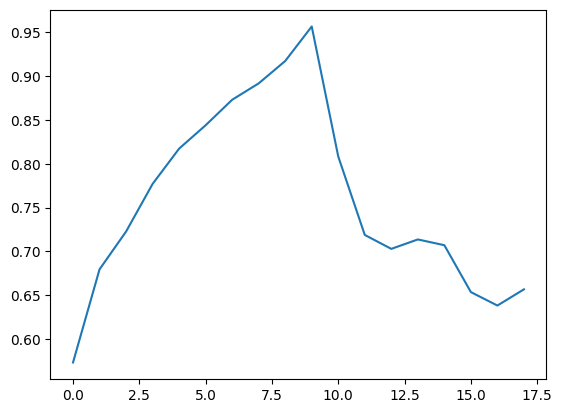

In [9]:
# cluster business's by positional data

# sample a fraction of the data to calculate silhouette score
def compute_kmeans_silhouette(k, data, sample_size=1000):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(data)

    # resample the data for faster silhouette score computation
    if len(data) > sample_size:
        data_sample, labels_sample = resample(data, cluster_labels, n_samples=sample_size, random_state=42)
        sil_score = silhouette_score(data_sample, labels_sample)
    else:
        sil_score = silhouette_score(data, cluster_labels)

    return kmeans.inertia_, sil_score

results = Parallel(n_jobs=-1)(delayed(compute_kmeans_silhouette)(k, data_businesses[['latitude_scaled', 'longitude_scaled']].values, sample_size=20000) for k in range(2, 20))
inertias, sil_scores = zip(*results)

plt.plot(sil_scores)
optimal_num_clusters = 11
